In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sklearn
from scipy import ndimage, misc
import math
%matplotlib inline
import cv2
import time
import glob

img_list = []
filenamelist= []
for img in glob.glob("0518ALL_Data/CCD-3/*.jpg"):
    #img_list.append(cv2.imread(img,0))
    filenamelist.append(img)
np.array(filenamelist).shape


Bad key "text.kerning_factor" on line 4 in
C:\Users\Chernger\Anaconda3\envs\tensorflow-gpu\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


(1011,)

In [3]:
'''
filename = '0525_images/CCD-3/ALL/0.jpg'
print(filename)
background = np.array(cv2.imread(filename,0))


plt.figure(figsize=(20,20))
plt.imshow(background,cmap = 'gray')
'''

"\nfilename = '0525_images/CCD-3/ALL/0.jpg'\nprint(filename)\nbackground = np.array(cv2.imread(filename,0))\n\n\nplt.figure(figsize=(20,20))\nplt.imshow(background,cmap = 'gray')\n"

In [122]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy import signal

#filename = '0525_images/CCD-3/14.jpg'
filename = '0525_images/CCD-3/51.jpg'
print(filename)
image = np.array(cv2.imread(filename,0))
backtorgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

#==============================================先用canny找出輪廓=============================================
ret, thresh1 = cv2.threshold(image, 70, 255, cv2.THRESH_BINARY_INV)
open_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,3))
thresh1 = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, open_kernel)

#plt.figure(figsize=(20,20))
#plt.imshow(image,cmap = 'gray')

# image_blur = cv2.blur(image,(9,9))
# canny = cv2.Canny(image_blur,5,20)
# plt.figure(figsize=(20,20))
# plt.imshow(canny,cmap = 'gray')

#==============================================用findcontours把canny得到的 ROI切出來=======================================

_ , contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
inner_contours_final = []
approx_list = []
index = []
for i in range(np.array(contours).shape[0]):
    if (hierarchy[0][i][3] >= 0):
        if(cv2.contourArea(contours[i])>300000 and cv2.contourArea(contours[i])<500000):
            #cv2.drawContours(backtorgb, contours, i, (0, 255, 0), 1, 8);
            #inner_contours_final.append(contours[i])
            epsilon = 0.005# * cv2.arcLength(contours[i],True)
            index.append(i)
            approx = cv2.approxPolyDP(contours[i], epsilon, True)
            print(cv2.contourArea(approx))
            approx_list.append(approx)
            #print(np.array(approx_list).shape)
            print(index)
            #cv2.polylines(backtorgb, [approx], True, (255,0, 0), 3)
            
            
            cv2.polylines(backtorgb, [approx], True, (255,0, 0), 3)
            
            
# plt.figure(figsize=(20,20))
# plt.imshow(backtorgb)

#==========================================外圓減內圓(外圓是面積最大那一個，index = 0 ，內圓面積最小，index = -1)
'''

inner_contour_img = np.zeros_like(image)
#cv2.drawContours(inner_contour_img, [approx_list[-1]],-1,(0,0,0),-1)
#inner_contour_img = 1 - inner_contour_img

outer_contour_img = np.zeros_like(image)
cv2.drawContours(outer_contour_img, [approx_list[0]],-1,(255,255,255),-1)
#outer_contour_img = 1 - outer_contour_img

#outer - inner
#oringmask = outer_contour_img- inner_contour_img
oringmask = outer_contour_img

#plt.figure(figsize=(20,20))
#plt.imshow(oringmask,cmap = 'gray')


#mask_image = oringmask*image
#mask_image = 1 - mask_image
image[oringmask == 0] = 255
#plt.figure(figsize=(20,20))
#plt.imshow(image,cmap = 'gray')
#plt.imsave("temp.jpg",image,cmap = 'gray')


'''
#==========================================找外接圓==============================================
ret, thresh1 = cv2.threshold(image, 110, 255, cv2.THRESH_BINARY_INV)

c,r = cv2.minEnclosingCircle(approx_list[0])
r = int(r)
cx = int(c[0])
cy = int(c[1])
print(r," ",cx," ",cy)
inner_contour_img = np.zeros_like(image)
cv2.circle(inner_contour_img,(cx,cy),(r+7), (255,255,255),-1)
#inner_contour_img = 1 - inner_contour_img
oringmask = inner_contour_img

image[oringmask == 0] = 255
backtorgb_inner_oring = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
backtorgb_inner_oring2 = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

cv2.circle(backtorgb_inner_oring,(cx,cy),(r+7), (0,255 ,0), 3)

#================================================從圓心射線================================
#image = cv2.blur(image,(3,3))
#kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
#image = cv2.filter2D(image, -1, kernel)
# plt.figure(figsize=(20,20))
# plt.imshow(image,cmap = 'gray')
#plt.imsave("image.jpg",image,cmap = 'gray')

ret, image_threshold = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY_INV)

open_kernel = np.ones((2,3),np.uint8)
#open_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,3))
image_threshold = cv2.morphologyEx(image_threshold, cv2.MORPH_OPEN, open_kernel)

# plt.figure(figsize=(20,20))
# plt.imshow(image_threshold,cmap = 'gray')

#plt.imsave("temp.jpg",thresh1,cmap = 'gray')

# '''=================================================================
# '''
# backtorgb_F = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

# close_kernel = np.ones((4,4),np.uint8)
# #open_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,3))
# image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, close_kernel)


# _ , contours, hierarchy = cv2.findContours(image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# inner_contours_final = []
# approx_list = []
# index = []
# for i in range(np.array(contours).shape[0]):
    
#     if (hierarchy[0][i][3] >= 0):
#         #if(cv2.contourArea(contours[i])>300000 and cv2.contourArea(contours[i])<500000):
#             epsilon = 0.05# * cv2.arcLength(contours[i],True)
#             index.append(i)
#             approx = cv2.approxPolyDP(contours[i], epsilon, True)
#             approx_list.append(approx)
            
#             cv2.polylines(backtorgb_F, [approx], True, (255,0, 0), 3)
            
            
# plt.figure(figsize=(20,20))
# plt.imshow(backtorgb_F)



#=====blur image=====
# image = cv2.blur(image,(3,3))
# kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
# image = cv2.filter2D(image, -1, kernel)
#=====================

const = np.pi/180
x = []
y = []
inner_x = []
inner_y = []

degree_delta = 0.5
for degree in range(int(360//degree_delta)):
    
    degree_real = degree_delta*degree
    now_x = int((r+2)*np.sin(degree_real*const))+cx
    now_y = int((r+2)*np.cos(degree_real*const))+cy
    now_inner_x = int((r-30)*np.sin(degree_real*const))+cx
    now_inner_y = int((r-30)*np.cos(degree_real*const))+cy

    x.append(now_x)
    y.append(now_y)
    inner_x.append(now_inner_x)
    inner_y.append(now_inner_y)


continuslist = []
all_diff_list = []
degree_1phase_list = []
all_min_list = []
threshold_1phase = 30
threshold_2phase = 10
for degree in range(720):
    points_on_line = np.linspace((inner_x[degree], inner_y[degree]),(x[degree],y[degree]) , 200, dtype = int)
    pass_list = image[points_on_line[:,1],points_on_line[:,0]]
    
    pass_list = gaussian_filter1d(pass_list,4)
    peaks, _ = find_peaks(pass_list, height=0, prominence = 10)
    valley, _ = find_peaks(-pass_list, height=0, prominence = 10)

    peak_and_valley_list = np.concatenate((pass_list[peaks], pass_list[valley]), axis=0)
#     fig, ax = plt.subplots( nrows=1, ncols=1 ) 
#     #plt.figure(figsize=(20,20))
#     ax.plot(pass_list)
#     ax.plot(peaks, pass_list[peaks], "x", color='green')
#     ax.plot(valley, pass_list[valley], "x", color='red')
#     fig.savefig('his/{}.png'.format(degree))# save the figure to file
#     plt.close(fig)

    # peak_and_valley_list 裡面存的是高峰和低谷的值，可能會有2 4 6，都是偶數，期望找出"最大的低谷和高峰差值"，再看有沒有>threshold
    
    shift_peak_and_valley_list = np.concatenate((np.array([0]), peak_and_valley_list))
    peak_and_valley_list = np.concatenate((peak_and_valley_list,np.array([0])))
    #print(shift_peak_and_valley_list)
    #print(peak_and_valley_list)
    diff_list = abs(peak_and_valley_list - shift_peak_and_valley_list)
    
    diff_list = diff_list[1::2]
    #print(peak_and_valley_list,diff_list)
#     print(degree)
    now_diff = max(diff_list)
    all_diff_list.append(now_diff)
    all_min_list.append(min(pass_list[valley]))
    
    if(min(pass_list[valley])>120 or max(diff_list)<threshold_1phase):
        degree_1phase_list.append(degree)
    
    #if(degree<=149 and degree>=149):
        #cv2.line(backtorgb_inner_oring,(inner_x[degree],inner_y[degree]),(x[degree],y[degree]),255,2)
        #cv2.circle(backtorgb_inner_oring,(x[degree],y[degree]),30, (0,255 ,255), 5)
        
for i in range(len(degree_1phase_list)):#第一階段有問題的degree，第二階段看看是不是真的有問題
    
    degree = degree_1phase_list[i]
    now_value = all_min_list[degree]
    prev_value = all_min_list[degree+1]
    next_value = all_min_list[degree-1]
    #print(abs(float(prev_value)-float(now_value)), " ", abs(float(next_value) - float(now_value)))
    
    if((abs(float(prev_value)-float(now_value))>threshold_2phase and abs(float(next_value) - float(now_value))>threshold_2phase)):
        cv2.line(backtorgb_inner_oring,(inner_x[degree],inner_y[degree]),(x[degree],y[degree]),255,2)
        cv2.circle(backtorgb_inner_oring,(x[degree],y[degree]),30, (0,255 ,255), 5)

plt.figure(figsize=(20,20))
#plt.imshow(backtorgb_inner_oring)
plt.imsave("temp.jpg",backtorgb_inner_oring)

0525_images/CCD-3/51.jpg
452730.0
[687]
381   1233   1066


<Figure size 1440x1440 with 0 Axes>

0525_images/CCD-3/5.jpg
Area:  596183.5
Area:  420818.0
444016.0
443387.0
421851.5
421234.0
603.5


IndexError: list index out of range

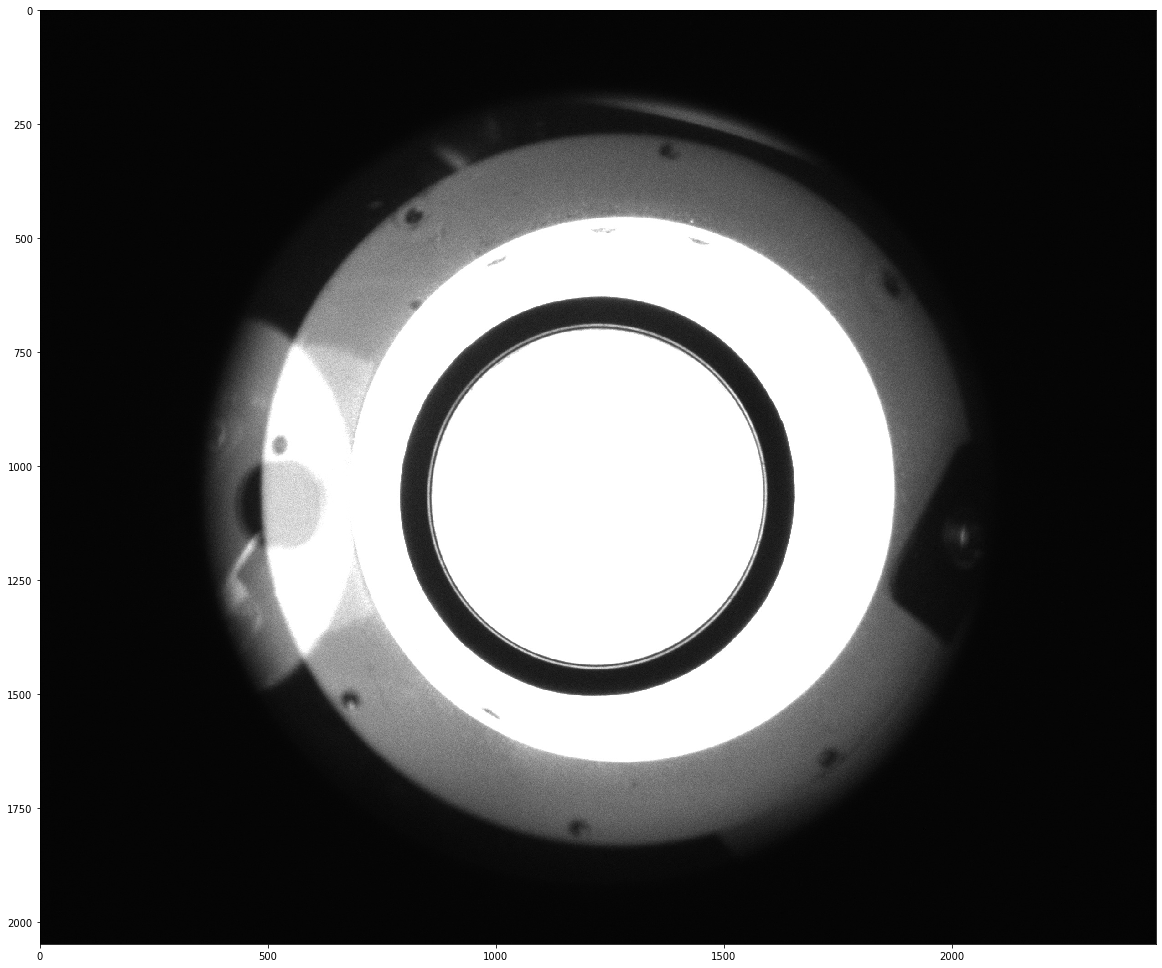

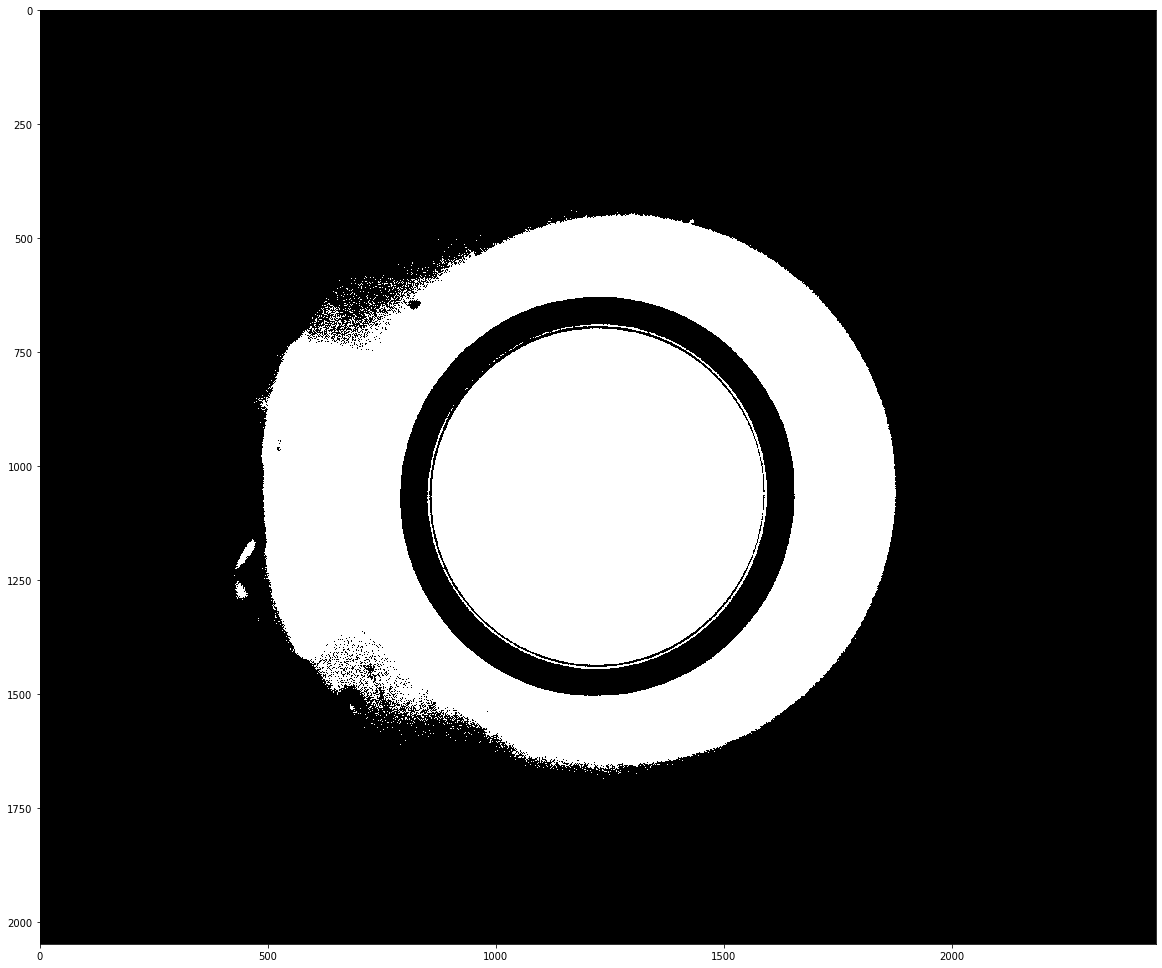

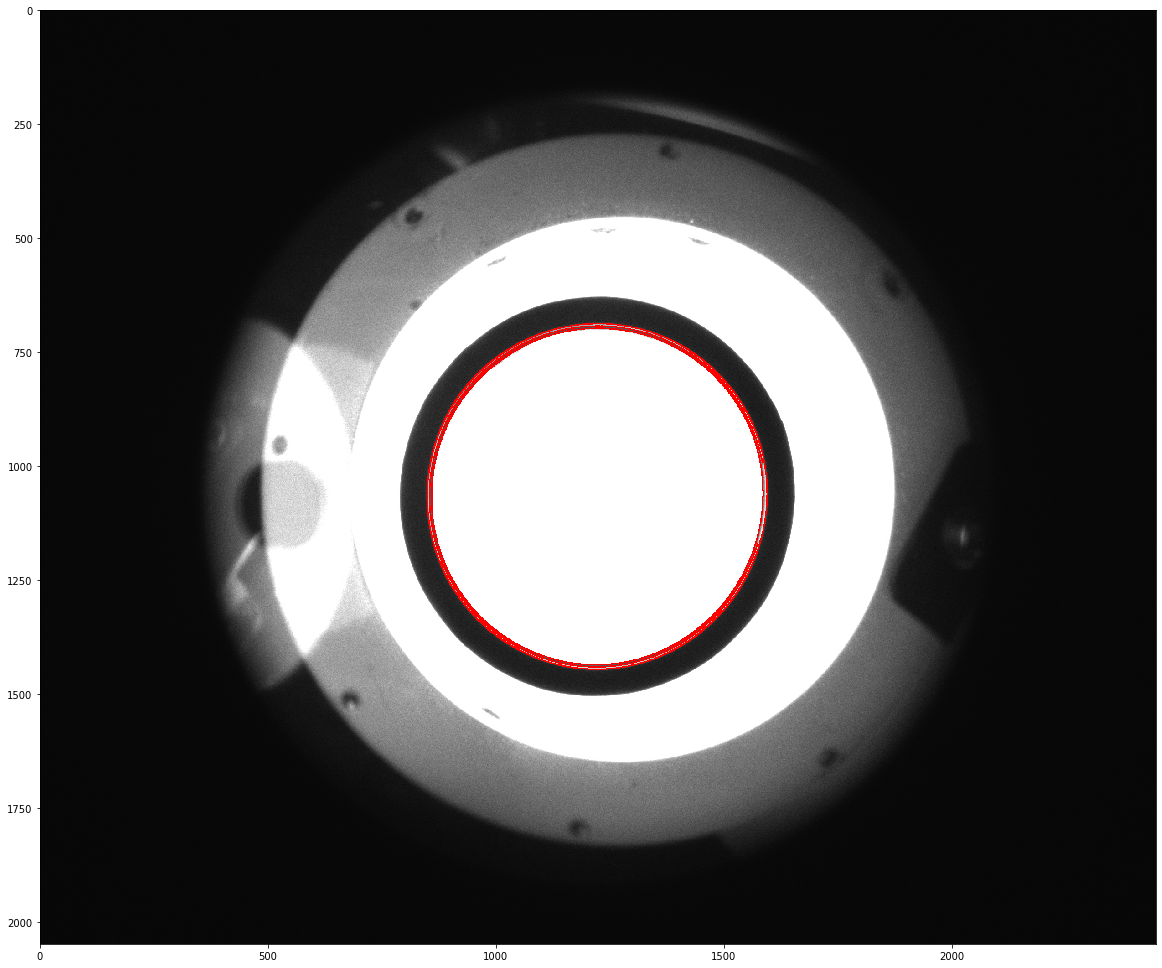

In [5]:
filename = '0525_images/CCD-3/5.jpg'
print(filename)
image = np.array(cv2.imread(filename,0))


#plt.figure(figsize=(20,20))
#plt.imshow(background,cmap = 'gray')

plt.figure(figsize=(20,20))
plt.imshow(image,cmap = 'gray')

backtorgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

ret, thresh1 = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(20,20))
plt.imshow(thresh1,cmap = 'gray')


#find contours1
_ , contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)


contours_final = []
approx_list = []
for i in range(np.array(contours).shape[0]):
        if(cv2.contourArea(contours[i])>300000 and cv2.contourArea(contours[i])<800000):
            contours_final.append(contours[i])
            #cv2.drawContours(backtorgb,contours[i],-1,(0,0,255),3)

            print("Area: ",cv2.contourArea(contours[i]))
            epsilon = 0.5# * cv2.arcLength(contours[i],True)
            approx = cv2.approxPolyDP(contours[i], epsilon, True)
            approx_list.append(approx)
            #cv2.polylines(backtorgb, [approx], True, (255, 0, 0), 2)
            
                
#plt.figure(figsize=(20,20))
#plt.imshow(backtorgb)

inner_contour_img = np.zeros_like(image)
cv2.drawContours(inner_contour_img, [approx_list[1]],-1,(255,255,255),-1)
inner_contour_img = 1 - inner_contour_img
#outer_contour_img = (outer_contour_img ==255).astype(int)

outer_contour_img = np.zeros_like(image)

cv2.drawContours(outer_contour_img, [approx_list[0]],-1,(255,255,255),-1)
outer_contour_img = 1 - outer_contour_img
#inner_contour_img = (inner_contour_img ==255).astype(int)

# for below delete contour after algorithm
delete_contour_img = np.zeros_like(image)
cv2.drawContours(delete_contour_img, [approx_list[0]],-1,(255,255,255),3)

#outer - inner
oringmask = outer_contour_img- inner_contour_img
#plt.figure(figsize=(20,20))
#plt.imshow(oringmask,cmap = 'gray')

mask_image = oringmask*image
#mask_image = 1 - mask_image
image[oringmask != 1] =255
#plt.figure(figsize=(20,20))
#plt.imshow(image,cmap = 'gray')

#==============以上找到Oring
canny = cv2.blur(image,(5,5))

#canny = cv2.Canny(canny,10,28)
canny = cv2.Canny(canny,10,30)
#image = thresh1*image
#plt.figure(figsize=(20,20))
#plt.imshow(canny,cmap = 'gray')


_ , contours, hierarchy = cv2.findContours(canny,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
inner_contours_final = []
inner_approx_list = []
index = []
for i in range(np.array(contours).shape[0]):
    if (hierarchy[0][i][3] >= 0):
        if(cv2.contourArea(contours[i])>100 and cv2.contourArea(contours[i])<500000):
            #cv2.drawContours(backtorgb, contours, i, (0, 255, 0), 1, 8);
            inner_contours_final.append(contours[i])
            epsilon = 0.005# * cv2.arcLength(contours[i],True)
            
            print(cv2.contourArea(contours[i]))
            index.append(i)
            approx = cv2.approxPolyDP(contours[i], epsilon, True)
            inner_approx_list.append(approx)
            cv2.polylines(backtorgb, [approx], True, (255, 0, 0), 2)

plt.figure(figsize=(20,20))
plt.imshow(backtorgb)

inner_contour_img = np.zeros_like(canny)
cv2.drawContours(inner_contour_img, [inner_approx_list[index[0]]],-1,(255,255,255),-1)
#inner_contour_img = 1 - inner_contour_img
image[inner_contour_img == 0] =255

plt.figure(figsize=(20,20))
plt.imshow(image,cmap = 'gray')
#plt.imsave("stop3.jpg",image,cmap = 'gray')

#======================================以上把黑線找出來了======================================

# ret, thresh1 = cv2.threshold(image, 80, 255, cv2.THRESH_BINARY_INV)
# #thresh1 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,19,12)
# #ret, thresh1 = cv2.threshold(image, 80, 255, cv2.THRESH_BINARY_INV)
# #plt.figure(figsize=(20,20))
# #plt.imshow(thresh1,cmap = 'gray')

# open_kernel = np.ones((2,3),np.uint8)
# OPEN_image = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, open_kernel)
# #plt.figure(figsize=(20,20))
# #plt.imshow(OPEN_image,cmap = 'gray')


# #close_kernel = np.ones((15,15),np.uint8)
# close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
# CLOSE_image = cv2.morphologyEx(OPEN_image, cv2.MORPH_CLOSE, close_kernel)
# plt.figure(figsize=(20,20))
# plt.imshow(CLOSE_image,cmap = 'gray')




# #=================================
# '''
# kernel = np.ones((15,15),np.uint8)  
# erosion = cv2.dilate(CLOSE_image,kernel,iterations = 1)
# plt.figure(figsize=(20,20))
# plt.imshow(erosion,cmap = 'gray')
# '''
# #==========================================
# New_image = np.zeros_like(image)
# New_image[CLOSE_image!=0] = 0
# New_image[CLOSE_image==0] = 255

# #plt.figure(figsize=(20,20))
# #plt.imshow(New_image,cmap = 'gray')
# #=========================================

# backtorgb_OPEN_image = cv2.cvtColor(New_image,cv2.COLOR_GRAY2RGB)
# _ , contours, hierarchy = cv2.findContours(New_image,cv2.RETR_TREE  ,cv2.CHAIN_APPROX_SIMPLE)
# inner_contours_final = []
# inner_approx_list = []
# index = []
# shapes = np.zeros((1,1,2),np.uint8)

# for i in range(np.array(contours).shape[0]):
#     #if(i==2):
#     if(i>0 ):
#         #cv2.drawContours(backtorgb, contours, i, (0, 255, 0), 1, 8);
#         inner_contours_final.append(contours[i])
#         shapes = np.append(shapes,np.array(contours[i]).reshape(-1,1,2),axis = 0)
#         epsilon = 0.05# * cv2.arcLength(contours[i],True)
#         index.append(i)
#         approx = cv2.approxPolyDP(contours[i], epsilon, True)
#         approx_list.append(approx)
#         #cv2.polylines(backtorgb_OPEN_image, [approx], True, (255, 0, 0), 2)
        
#         #print(approx.reshape(-1,1,2))
#         '''
#         boundRect = cv2.minAreaRect(approx)
#         boundRect = cv2.boxPoints(boundRect)
#         boundRect = np.int0(boundRect)
#         print(boundRect)
#         '''
#         #cv2.drawContours(backtorgb_OPEN_image, [boundRect], 0, (0, 255, 0), 3 );
#         #cv2.circle(backtorgb_OPEN_image,(approx[0][0][0],approx[0][0][1]), 8, (0,0 ,0), -1)
#         #cv2.circle(backtorgb_OPEN_image,(approx[approx.shape[0]//2][0][0],approx[approx.shape[0]//2][0][1]), 8, (0,255 ,0), -1)
#         #cv2.rectangle(backtorgb_OPEN_image, (int(boundRect[0]), int(boundRect[1])),(int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), (0,0 ,255), 4)
#         cv2.drawContours(backtorgb_OPEN_image, [approx], 0, (255, 0, 0), -1 );
#         #print(approx.shape)
        
# #approx = cv2.approxPolyDP([approx_list], epsilon, True)
 

# New_image = np.zeros_like(image)
# New_image[backtorgb_OPEN_image[...,2]==255]=0
# New_image[backtorgb_OPEN_image[...,2]!=255]=255

# #open_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
# New_image_OPEN = cv2.morphologyEx(CLOSE_image, cv2.MORPH_OPEN, open_kernel)

# '''
# #close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(21,21))
# #kernel = np.ones((30,30),np.uint8)  
# #New_image_CLOSED = cv2.morphologyEx(New_image_OPEN, cv2.MORPH_CLOSE, close_kernel)   

# #close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(200,200))
# #kernel = np.ones((30,30),np.uint8)  
# #New_image_CLOSED2 = cv2.morphologyEx(New_image_CLOSED, cv2.MORPH_CLOSE, close_kernel)  
# '''


# #========test for find defect=========================
# #New_image_OPEN = CLOSE_image 
# plt.figure(figsize=(20,20))
# plt.imshow(New_image_OPEN,cmap = 'gray')
# #======================================================
# backtorgb_OPEN_image = cv2.cvtColor(New_image_OPEN,cv2.COLOR_GRAY2RGB)
# _ , contours, hierarchy = cv2.findContours(New_image_OPEN,cv2.RETR_CCOMP  ,cv2.CHAIN_APPROX_NONE)
# inner_contours_final = []
# inner_approx_list = []
# index = []
# shapes = np.zeros((1,1,2),np.uint8)

# for i in range(np.array(contours).shape[0]):
#     #if(i==2):
#     if(cv2.contourArea(contours[i])>5 and cv2.contourArea(contours[i])<500000):
#         #cv2.drawContours(backtorgb, contours, i, (0, 255, 0), 1, 8);
#         inner_contours_final.append(contours[i])
#         shapes = np.append(shapes,np.array(contours[i]).reshape(-1,1,2),axis = 0)
#         epsilon = 5# * cv2.arcLength(contours[i],True)
#         index.append(i)
#         approx = cv2.approxPolyDP(contours[i], epsilon, False)
#         approx_list.append(approx)
#         #cv2.circle(backtorgb_OPEN_image,(approx[0][0][0],approx[0][0][1]), 8, (0,255 ,0), -1)
#         #cv2.circle(backtorgb_OPEN_image,(approx[-1][0][0],approx[-1][0][1]), 8, (0,255 ,0), -1)
#         #cv2.drawContours(backtorgb_OPEN_image, [approx], 0, (255, 0, 0), -1 );
#         #print(approx.shape)

# shapes = shapes[1:]
# epsilon = 20
# approx = cv2.approxPolyDP(shapes, epsilon, False)
# '''
# #defects = cv2.convexityDefects(shapes,hull)
# print(approx.shape)
# cv2.drawContours(backtorgb_OPEN_image, [approx], 0, (255, 255, 255), -1 );
# '''

# c,r = cv2.minEnclosingCircle(approx)
# r = int(r)
# cx = int(c[0])
# cy = int(c[1])
# print(int(c[0]))
# New_image = np.zeros_like(image)
# New_image[backtorgb_OPEN_image[...,2]==255]=255
# New_image[backtorgb_OPEN_image[...,2]!=255]=0
# cv2.circle(backtorgb_OPEN_image,(cx,cy),(r+5), (0,255 ,0), 3)
# for degree in range(1000):
#     x = int((r+5)*np.sin(degree))+cx
#     y = int((r+5)*np.cos(degree))+cy
    
#     points_on_line = np.linspace((int(c[0]), int(c[1])),(x,y) ,500,dtype = int)
#     pass_list = New_image_OPEN[points_on_line[:,1],points_on_line[:,0]]
#     if(sum(pass_list)<=1000):
#         cv2.line(backtorgb_OPEN_image,(int(c[0]),int(c[1])),(x,y),255,2)
#         cv2.circle(backtorgb_OPEN_image,(x,y),15, (0,255 ,255), 5)
# plt.figure(figsize=(20,20))
# plt.imshow(backtorgb_OPEN_image)


## Temp

0525_images/CCD-3/18.jpg
418545.5
417943.0
367   1227   1063


C:\Users\Chernger\Anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Chernger\Anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan
0   nan


'\n1.找到那一圈黑色的\n2.找外接圓\n3.從圓心往外射，看射到的pixel 0 和255分布(0太少表示是斷裂)\n\n想法:degree太少，插入幾根在這些degree當中(本來是1度一單位)\n'

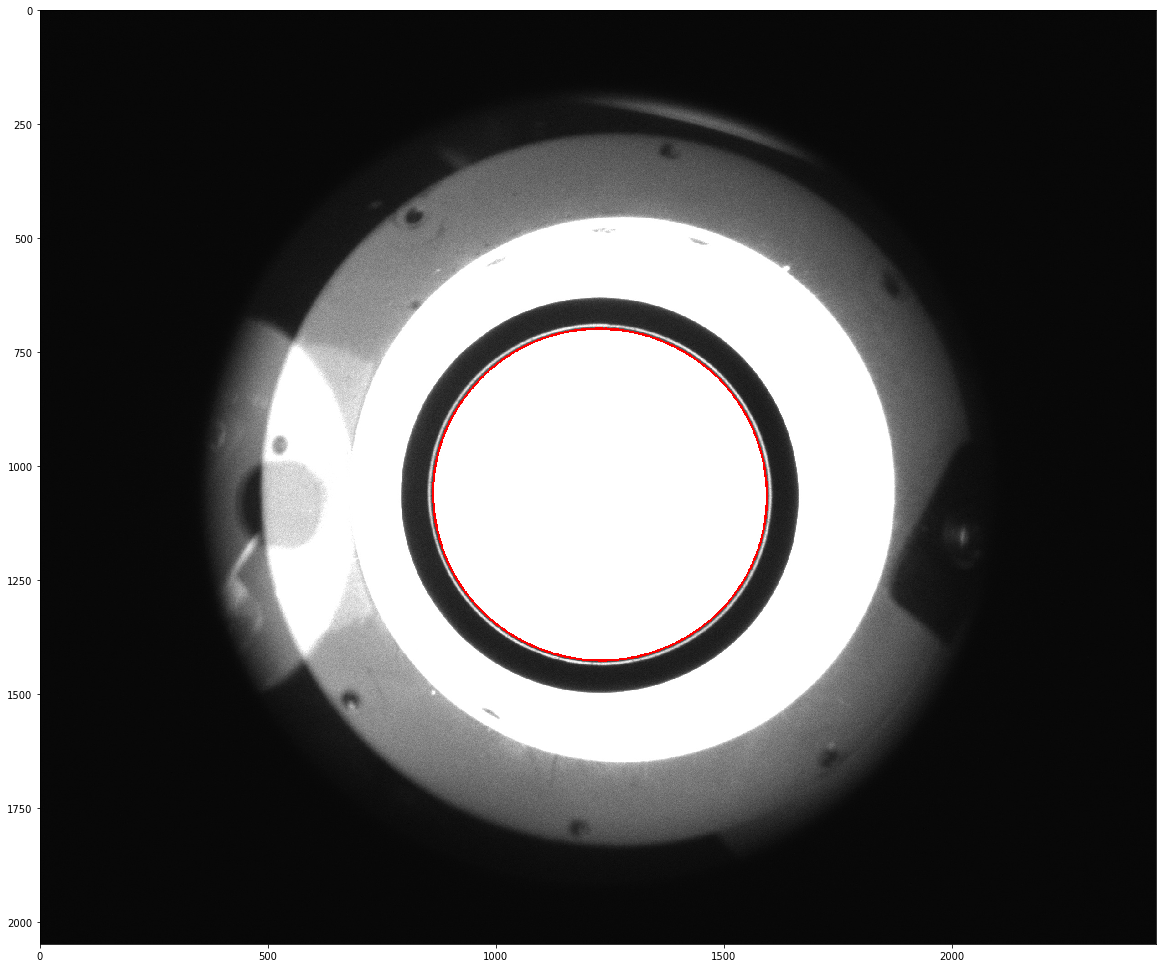

<Figure size 1440x1440 with 0 Axes>

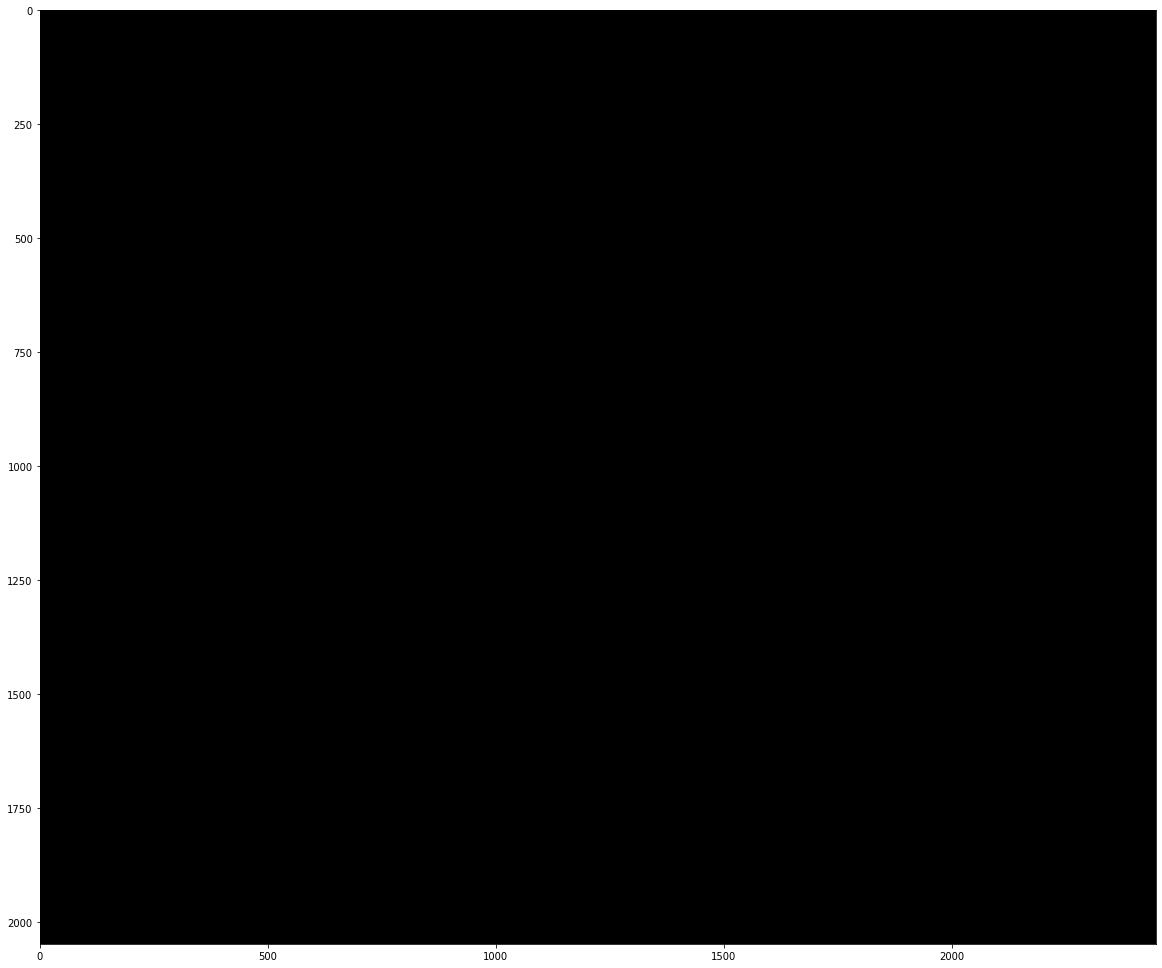

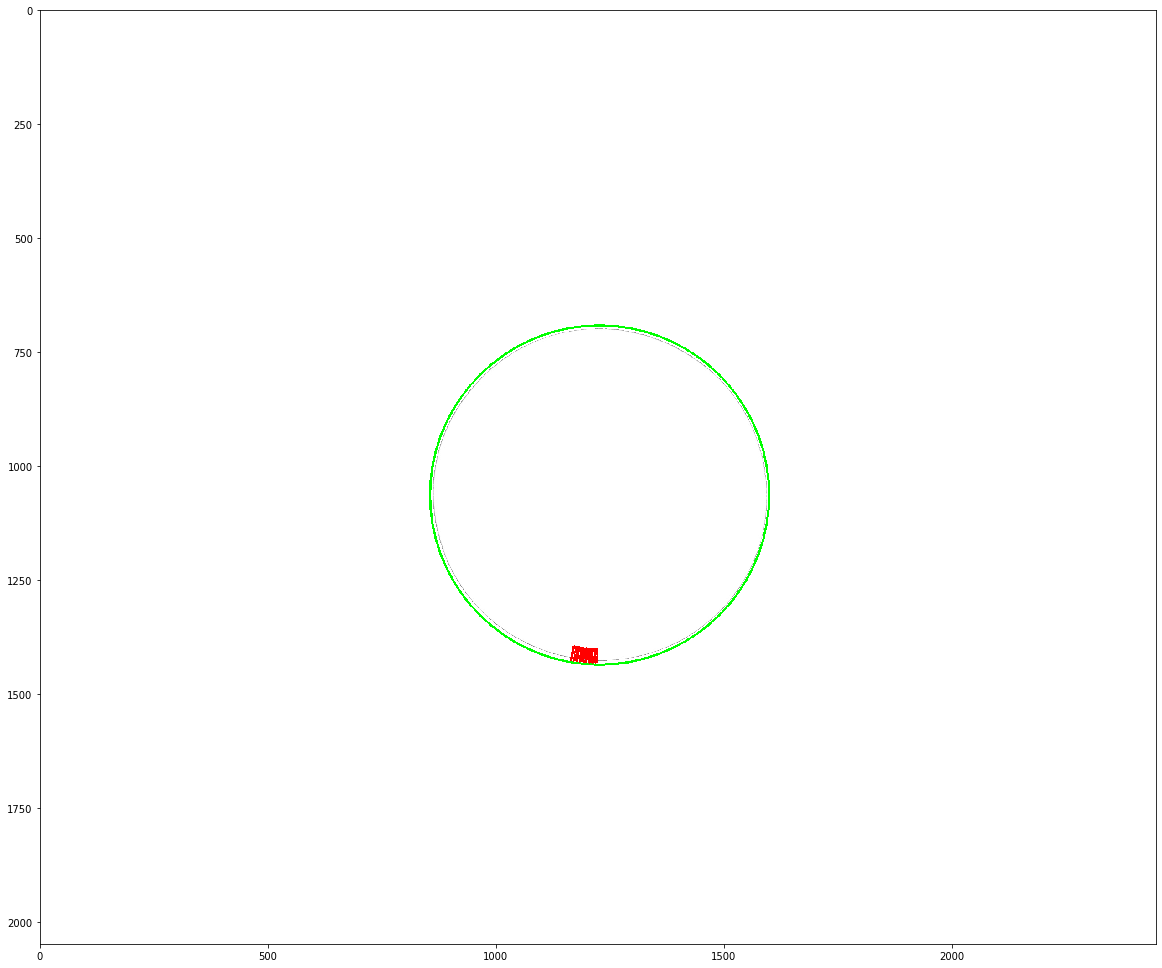

In [6]:
filename = '0525_images/CCD-3/18.jpg'
print(filename)
image = np.array(cv2.imread(filename,0))
backtorgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

#==============================================先用canny找出輪廓=============================================

#plt.figure(figsize=(20,20))
#plt.imshow(image,cmap = 'gray')

image_blur = cv2.blur(image,(5,5))
canny = cv2.Canny(image_blur,5,15)
#plt.figure(figsize=(20,20))
#plt.imshow(canny,cmap = 'gray')

#==============================================用findcontours把canny得到的 ROI切出來=======================================

_ , contours, hierarchy = cv2.findContours(canny,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
inner_contours_final = []
approx_list = []
index = []
for i in range(np.array(contours).shape[0]):
    if (hierarchy[0][i][3] >= 0):
        if(cv2.contourArea(contours[i])>300000 and cv2.contourArea(contours[i])<500000):
            #cv2.drawContours(backtorgb, contours, i, (0, 255, 0), 1, 8);
            #inner_contours_final.append(contours[i])
            epsilon = 0.005# * cv2.arcLength(contours[i],True)
            index.append(i)
            approx = cv2.approxPolyDP(contours[i], epsilon, True)
            print(cv2.contourArea(approx))
            approx_list.append(approx)
            #print(np.array(approx_list).shape)
            cv2.polylines(backtorgb, [approx], True, (255,0, 0), 3)

plt.figure(figsize=(20,20))
plt.imshow(backtorgb)

#==========================================外圓減內圓(外圓是面積最大那一個，index = 0 ，內圓面積最小，index = -1)

inner_contour_img = np.zeros_like(image)
cv2.drawContours(inner_contour_img, [approx_list[-1]],-1,(0,0,0),-1)
#inner_contour_img = 1 - inner_contour_img

outer_contour_img = np.zeros_like(image)
cv2.drawContours(outer_contour_img, [approx_list[0]],-1,(255,255,255),-1)
#outer_contour_img = 1 - outer_contour_img

#outer - inner
#oringmask = outer_contour_img- inner_contour_img
oringmask = outer_contour_img
#plt.figure(figsize=(20,20))
#plt.imshow(oringmask,cmap = 'gray')


mask_image = oringmask*image
#mask_image = 1 - mask_image
image[oringmask == 0] =255
plt.figure(figsize=(20,20))
#plt.imshow(image,cmap = 'gray')
#plt.imsave("temp.jpg",image,cmap = 'gray')
backtorgb_inner_oring = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
#==========================================找外接圓==============================================
ret, thresh1 = cv2.threshold(image, 110, 255, cv2.THRESH_BINARY_INV)

c,r = cv2.minEnclosingCircle(approx_list[0])
r = int(r)
cx = int(c[0])
cy = int(c[1])
print(r," ",cx," ",cy)
cv2.circle(backtorgb_inner_oring,(cx,cy),(r+5), (0,255 ,0), 3)

#================================================從圓心射線================================
image = cv2.blur(image,(3,3))
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
image = cv2.filter2D(image, -1, kernel)
#plt.figure(figsize=(20,20))
#plt.imshow(image,cmap = 'gray')


ret, image = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY_INV)

open_kernel = np.ones((2,3),np.uint8)
#open_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,3))
image = cv2.morphologyEx(image, cv2.MORPH_OPEN, open_kernel)

plt.figure(figsize=(20,20))
plt.imshow(image,cmap = 'gray')
plt.imsave("temp.jpg",thresh1,cmap = 'gray')

#=====blur image=====
#image = cv2.blur(image,(2,3))
#=====================

const = np.pi/180
x = []
y = []
inner_x = []
inner_y = []

for degree in range(360):
    
    now_x = int((r+2)*np.sin(degree*const))+cx
    now_y = int((r+2)*np.cos(degree*const))+cy
    now_inner_x = int((r-30)*np.sin(degree*const))+cx
    now_inner_y = int((r-30)*np.cos(degree*const))+cy
    
    if(degree>0):
        prev_x = x[-1]
        prev_y = y[-1]
        prev_inner_x = inner_x[-1]
        prev_inner_y = inner_y[-1]
        
        x.append((now_x+prev_x)//2)
        y.append((now_y+prev_y)//2)
        inner_x.append((now_inner_x+prev_inner_x)//2)
        inner_y.append((now_inner_y+prev_inner_y)//2)
        
    x.append(now_x)
    y.append(now_y)
    inner_x.append(now_inner_x)
    inner_y.append(now_inner_y)

for degree in range(719):
    points_on_line = np.linspace((inner_x[degree], inner_y[degree]),(x[degree],y[degree]) ,200,dtype = int)
    pass_list = image[points_on_line[:,1],points_on_line[:,0]]
    if(degree >= 700 and degree <=720):
    #if(sum(pass_list[pass_list<120])<=5000 and sum(pass_list[pass_list<120])>=4000):
    #if(np.mean(pass_list[pass_list<230])>150):
    #if(len(pass_list[pass_list==255])<15):
        #cv2.line(backtorgb_inner_oring,(cx,cy),(x,y),255,2)
        print(len(pass_list[pass_list==255])," ", np.mean(pass_list[pass_list==255]))
        cv2.line(backtorgb_inner_oring,(inner_x[degree],inner_y[degree]),(x[degree],y[degree]),255,2)
        #cv2.circle(backtorgb_inner_oring,(x,y),30, (0,255 ,255), 5)
        #print(np.mean(pass_list[pass_list<100]))
        #print(sum(pass_list[pass_list<80]))

plt.figure(figsize=(20,20))
plt.imshow(backtorgb_inner_oring)
plt.imsave("stop3.jpg",backtorgb_inner_oring)
#======================pipeline========================
'''
1.找到那一圈黑色的
2.找外接圓
3.從圓心往外射，看射到的pixel 0 和255分布(0太少表示是斷裂)

想法:degree太少，插入幾根在這些degree當中(本來是1度一單位)
'''
#======================parameter=======================



## Try crop black circle

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sklearn
from scipy import ndimage, misc
import math
%matplotlib inline
import cv2
import time
import glob

img_list = []
filenamelist= []
for img in glob.glob("0525_images/CCD-3/problems/*.jpg"):
    #img_list.append(cv2.imread(img,0))
    filenamelist.append(img)
np.array(filenamelist).shape

for iter_file in range(len(filenamelist)):
    
    #==============read in file==============================
#     start = time.time()
    filename = filenamelist[iter_file]
    print(filename)
    image = np.array(cv2.imread(filename,0))
#     backtorgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

# #filename = '0525_images/CCD-3\problems\8.jpg'
# filename = '0525_images\\CCD-3\\15.jpg'
# print(filename)
# image = np.array(cv2.imread(filename,0))

    ret, thresh1 = cv2.threshold(image, 70, 255, cv2.THRESH_BINARY_INV)

    #open_kernel = np.ones((2,3),np.uint8)
    open_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,3))
    thresh1 = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, open_kernel)
    #plt.figure(figsize=(20,20))
    #plt.imshow(thresh1,cmap = 'gray')


    backtorgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

    #==============================================先用canny找出輪廓=============================================

    #plt.figure(figsize=(20,20))
    #plt.imshow(image,cmap = 'gray')

    #image_blur = cv2.blur(image,(9,9))
    #canny = cv2.Canny(image,17,255)
    #plt.figure(figsize=(20,20))
    #plt.imshow(canny,cmap = 'gray')

    #==============================================用findcontours把canny得到的 ROI切出來=======================================

    _ , contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    inner_contours_final = []
    approx_list = []
    index = []
    for i in range(np.array(contours).shape[0]):
        if (hierarchy[0][i][3] >= 0):
            if(cv2.contourArea(contours[i])>300000 and cv2.contourArea(contours[i])<500000):
                #cv2.drawContours(backtorgb, contours, i, (0, 255, 0), 1, 8);
                #inner_contours_final.append(contours[i])
                epsilon = 0.005# * cv2.arcLength(contours[i],True)
                index.append(i)
                approx = cv2.approxPolyDP(contours[i], epsilon, True)
                print(cv2.contourArea(approx))
                approx_list.append(approx)
                #print(np.array(approx_list).shape)
                print(index)
                #cv2.polylines(backtorgb, [approx], True, (255,0, 0), 3)


                cv2.polylines(backtorgb, [approx], True, (0,0, 255), 3)


    
    #plt.figure(figsize=(20,20))
    #plt.imshow(backtorgb)



    oringmask = np.zeros_like(image)
    cv2.drawContours(oringmask, [approx_list[0]],-1,(255,255,255),-1)

    image[oringmask == 0] =255
    #plt.figure(figsize=(20,20))
    #plt.imshow(image,cmap = 'gray')
    #plt.imsave("stop3.jpg",backtorgb)
    print(".\\Detect\\Stop3\\" +filenamelist[iter_file][18:-4]+'_Detect.jpg')
    cv2.imwrite(".\\Detect\\Stop3\\" +filenamelist[iter_file][18:-4]+'_Detect.jpg',backtorgb)


0525_images/CCD-3/problems\117.jpg
450452.0
[699]
.\Detect\Stop3\problems\117_Detect.jpg
0525_images/CCD-3/problems\145.jpg
442960.0
[774]
.\Detect\Stop3\problems\145_Detect.jpg
0525_images/CCD-3/problems\152.jpg
446019.0
[715]
.\Detect\Stop3\problems\152_Detect.jpg
0525_images/CCD-3/problems\25.jpg
442833.5
[641]
.\Detect\Stop3\problems\25_Detect.jpg
0525_images/CCD-3/problems\53.jpg
447724.0
[676]
.\Detect\Stop3\problems\53_Detect.jpg
0525_images/CCD-3/problems\65.jpg
455703.5
[705]
.\Detect\Stop3\problems\65_Detect.jpg
0525_images/CCD-3/problems\72.jpg
446952.0
[718]
.\Detect\Stop3\problems\72_Detect.jpg
0525_images/CCD-3/problems\8.jpg
443130.5
[675]
.\Detect\Stop3\problems\8_Detect.jpg


In [235]:
for i in range(0,720,1):
    print(i*0.5)

0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5
10.0
10.5
11.0
11.5
12.0
12.5
13.0
13.5
14.0
14.5
15.0
15.5
16.0
16.5
17.0
17.5
18.0
18.5
19.0
19.5
20.0
20.5
21.0
21.5
22.0
22.5
23.0
23.5
24.0
24.5
25.0
25.5
26.0
26.5
27.0
27.5
28.0
28.5
29.0
29.5
30.0
30.5
31.0
31.5
32.0
32.5
33.0
33.5
34.0
34.5
35.0
35.5
36.0
36.5
37.0
37.5
38.0
38.5
39.0
39.5
40.0
40.5
41.0
41.5
42.0
42.5
43.0
43.5
44.0
44.5
45.0
45.5
46.0
46.5
47.0
47.5
48.0
48.5
49.0
49.5
50.0
50.5
51.0
51.5
52.0
52.5
53.0
53.5
54.0
54.5
55.0
55.5
56.0
56.5
57.0
57.5
58.0
58.5
59.0
59.5
60.0
60.5
61.0
61.5
62.0
62.5
63.0
63.5
64.0
64.5
65.0
65.5
66.0
66.5
67.0
67.5
68.0
68.5
69.0
69.5
70.0
70.5
71.0
71.5
72.0
72.5
73.0
73.5
74.0
74.5
75.0
75.5
76.0
76.5
77.0
77.5
78.0
78.5
79.0
79.5
80.0
80.5
81.0
81.5
82.0
82.5
83.0
83.5
84.0
84.5
85.0
85.5
86.0
86.5
87.0
87.5
88.0
88.5
89.0
89.5
90.0
90.5
91.0
91.5
92.0
92.5
93.0
93.5
94.0
94.5
95.0
95.5
96.0
96.5
97.0
97.5
98.0
98.5
99.0
99.5
100.0
100.5
101.0
10